In [123]:
from transformers import pipeline
from nltk import sent_tokenize
import torch
from glob import glob


In [2]:
import pandas as pd
import numpy as np

# Load Model

In [90]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [92]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [93]:
theme_classifier = load_model(device)

In [6]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [11]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121254086494446,
  0.47500181198120117,
  0.0878182053565979,
  0.045000456273555756,
  0.020132921636104584,
  0.012040475383400917,
  0.0042923809960484505,
  0.002817221451550722]}

# Load Dataset

In [14]:
df = pd.read_csv("C:/work/ml/analyze_series_with_NLP/data/GOT.csv")

In [15]:
df = df.drop(['Release Date','Episode Title'] , axis=1)

In [16]:
df.head()

,Season,Episode,Name,Sentence
0,Season 1,Episode 1,waymar royce,What do you expect? They're savages. One lot s...
1,Season 1,Episode 1,will,I've never seen wildlings do a thing like this...
2,Season 1,Episode 1,waymar royce,How close did you get?
3,Season 1,Episode 1,will,Close as any man would.
4,Season 1,Episode 1,gared,We should head back to the wall.


In [17]:
# Create a new column with both season and episode info for each row
df['season_episode'] = (df['Season'].str.split(' ').str[1].astype(int) - 1) * 10 + df['Episode'].str.split(' ').str[1].astype(int)



In [18]:
df.head()

,Season,Episode,Name,Sentence,season_episode
0,Season 1,Episode 1,waymar royce,What do you expect? They're savages. One lot s...,1
1,Season 1,Episode 1,will,I've never seen wildlings do a thing like this...,1
2,Season 1,Episode 1,waymar royce,How close did you get?,1
3,Season 1,Episode 1,will,Close as any man would.,1
4,Season 1,Episode 1,gared,We should head back to the wall.,1


In [19]:
df_a = df.drop(['Season','Episode'],axis=1)

In [20]:
df_a['Sentence'] = df_a['Sentence'].astype(str)

In [12]:
df_a = df_a.groupby('season_episode')['Sentence'].agg(' '.join).reset_index()


In [21]:
df_a.head()

,Name,Sentence,season_episode
0,waymar royce,What do you expect? They're savages. One lot s...,1
1,will,I've never seen wildlings do a thing like this...,1
2,waymar royce,How close did you get?,1
3,will,Close as any man would.,1
4,gared,We should head back to the wall.,1


In [78]:
def load_subtitles_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    df['season_episode'] = (df['Season'].str.split(' ').str[1].astype(int) - 1) * 10 + df['Episode'].str.split(' ').str[1].astype(int)
    df_a = df.drop(['Season','Episode','Name','Release Date','Episode Title'],axis=1)
    df_a['Sentence'] = df_a['Sentence'].astype(str)
    df_a = df_a.groupby('season_episode')['Sentence'].agg(' '.join).reset_index()
    df_a.rename(columns={'Sentence':'Subtitles'},inplace=True)
    
    


    return df_a

In [22]:
def load_subtitles_dataset_classified(dataset_path):
    df = pd.read_csv(dataset_path)
    df['season_episode'] = (df['Season'].str.split(' ').str[1].astype(int) - 1) * 10 + df['Episode'].str.split(' ').str[1].astype(int)
    df_a = df.drop(['Season','Episode','Release Date','Episode Title'],axis=1)
    df_a['Sentence'] = df_a['Sentence'].astype(str)
    df_a.rename(columns={'Sentence':'Subtitles'},inplace=True)
    
    return df_a

In [23]:
df_test = load_subtitles_dataset_classified("C:/work/ml/analyze_series_with_NLP/data/GOT.csv")
df_test.head()

,Name,Subtitles,season_episode
0,waymar royce,What do you expect? They're savages. One lot s...,1
1,will,I've never seen wildlings do a thing like this...,1
2,waymar royce,How close did you get?,1
3,will,Close as any man would.,1
4,gared,We should head back to the wall.,1


In [79]:
dataset_path = "C:/work/ml/analyze_series_with_NLP/data/GOT.csv"
df = load_subtitles_dataset(dataset_path)

In [80]:
df.head()

,season_episode,Subtitles
0,1,What do you expect? They're savages. One lot s...
1,2,"You need to drink, child... And eat. Isn't the..."
2,3,"Welcome, Lord Stark. Grand Maester Pycelle has..."
3,4,The little Lordo s been dreaming again. We hav...
4,5,Does Ser Hugh have any family in the capital? ...


Run Model

In [81]:
script = df.iloc[0]['Subtitles']

In [82]:
script

"What do you expect? They're savages. One lot steals a goat from another lot and before you know it, they're ripping each other to pieces. I've never seen wildlings do a thing like this. I've never seen a thing like this, not ever in my life. How close did you get? Close as any man would. We should head back to the wall. Do the dead frighten you? Our orders were to track the wildlings. We tracked them. They won't trouble us no more. You don't think he'll ask us how they died? Get back on your horse. Whatever did it to them could do it to us. They even killed the children. It's a good thing we're not children. You want to run away south, run away. Of course, they will behead you as a deserter … If I don't catch you first. Get back on your horse. I won't say it again. Your dead men seem to have moved camp. They were here. See where they went. What is it? It's … Go on. Father's watching. And your mother. Fine work, as always. Well done. Thank you. I love the detail that you've managed to 

In [86]:
!import nltk
nltk.download('punkt_tab')

'import' is not recognized as an internal or external command,
operable program or batch file.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [87]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['What do you expect?',
 "They're savages.",
 "One lot steals a goat from another lot and before you know it, they're ripping each other to pieces."]

In [88]:
# Batch Sentence
sentence_batch_size=20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [99]:
script_batches[:5]

["What do you expect? They're savages. One lot steals a goat from another lot and before you know it, they're ripping each other to pieces. I've never seen wildlings do a thing like this. I've never seen a thing like this, not ever in my life. How close did you get? Close as any man would. We should head back to the wall. Do the dead frighten you? Our orders were to track the wildlings. We tracked them. They won't trouble us no more. You don't think he'll ask us how they died? Get back on your horse. Whatever did it to them could do it to us. They even killed the children. It's a good thing we're not children. You want to run away south, run away. Of course, they will behead you as a deserter … If I don't catch you first. Get back on your horse.",
 "I won't say it again. Your dead men seem to have moved camp. They were here. See where they went. What is it? It's … Go on. Father's watching. And your mother. Fine work, as always. Well done. Thank you. I love the detail that you've manage

In [100]:
theme_list = ["friendship","hope","arrogance","battle","fear","betrayal","love","dialogue"]

In [102]:
theme_output = theme_classifier(
    script_batches[:5],
    theme_list,
    multi_label=True
)

In [103]:
theme_output

[{'sequence': "What do you expect? They're savages. One lot steals a goat from another lot and before you know it, they're ripping each other to pieces. I've never seen wildlings do a thing like this. I've never seen a thing like this, not ever in my life. How close did you get? Close as any man would. We should head back to the wall. Do the dead frighten you? Our orders were to track the wildlings. We tracked them. They won't trouble us no more. You don't think he'll ask us how they died? Get back on your horse. Whatever did it to them could do it to us. They even killed the children. It's a good thing we're not children. You want to run away south, run away. Of course, they will behead you as a deserter … If I don't catch you first. Get back on your horse.",
  'labels': ['fear',
   'dialogue',
   'betrayal',
   'arrogance',
   'battle',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9723045825958252,
   0.9718348383903503,
   0.9577839970588684,
   0.9164268374443054,
   0.85

In [104]:
# Wrangle Ouput
# battle: [0.51489498, 0.2156498]
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [105]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

In [109]:
themes

{'fear': 0.6803902745246887,
 'dialogue': 0.9003806471824646,
 'betrayal': 0.7766735255718231,
 'arrogance': 0.6649132668972015,
 'battle': 0.7522260963916778,
 'hope': 0.3994742199778557,
 'friendship': 0.2647804394364357,
 'love': 0.16340405493974686}

In [110]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [111]:
df = df.head(2)

In [112]:
output_themes = df['Subtitles'].apply(get_themes_inference)

In [113]:
output_themes

0    {'fear': 0.5596044659614563, 'dialogue': 0.834...
1    {'dialogue': 0.9263494908809662, 'betrayal': 0...
Name: Subtitles, dtype: object

In [114]:
theme_df = pd.DataFrame(output_themes.tolist())

In [115]:
theme_df

,fear,dialogue,betrayal,arrogance,battle,hope,friendship,love
0,0.559604,0.834423,0.518273,0.556391,0.608582,0.337443,0.114487,0.148685
1,0.535356,0.926349,0.541051,0.527074,0.512554,0.630392,0.352747,0.248005


In [117]:
df

,season_episode,Subtitles,fear,dialogue,betrayal,arrogance,battle,hope,friendship,love
0,1,What do you expect? They're savages. One lot s...,0.559604,0.834423,0.518273,0.556391,0.608582,0.337443,0.114487,0.148685
1,2,"You need to drink, child... And eat. Isn't the...",0.535356,0.926349,0.541051,0.527074,0.512554,0.630392,0.352747,0.248005


In [116]:
df[theme_df.columns] = theme_df
df

,season_episode,Subtitles,fear,dialogue,betrayal,arrogance,battle,hope,friendship,love
0,1,What do you expect? They're savages. One lot s...,0.559604,0.834423,0.518273,0.556391,0.608582,0.337443,0.114487,0.148685
1,2,"You need to drink, child... And eat. Isn't the...",0.535356,0.926349,0.541051,0.527074,0.512554,0.630392,0.352747,0.248005


# Visualize ouput

In [119]:
df = df.drop('dialogue',axis=1)

In [120]:
theme_output = df.drop(['season_episode'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,fear,1.094961
1,betrayal,1.059324
2,arrogance,1.083465
3,battle,1.121136
4,hope,0.967835
5,friendship,0.467234
6,love,0.396691


In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

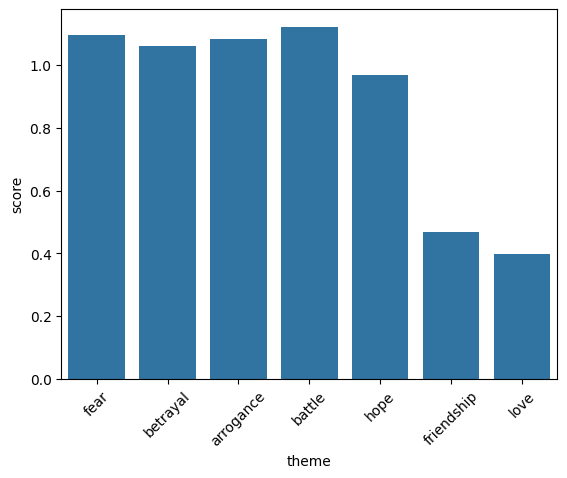

In [122]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()